# PyTorch Neural Network Classification

Classification broadly means predicting whether something is one thing or another.

- `Binary classification`: target can be one of two options (e.g. cat or dog)
- `Multi-class classification`: target can be one of many options (e.g. cat, dog, bird, etc.)
- `Multi-label classification`: target can be assigned more than one option (e.g. image with cat, dog, and bird)

#### General architecture of a classification neural network:

| Hyperparameter | Binary Classification | Multiclass Classification |
| :-: | :-: | :-: |
| Input layer shape | Same as number of features | Same as number of features |
| Hidden layers | Problem specific; min = 1, max = inf | Problem specific; min = 1, max = inf |
| Neurons per hidden layer | Problem specific; generally 10-512 | Problem specific; generally 10-512 |
| Output layer shape | 1 | Same as number of classes |
| Hidden layer activation | Usually ReLU | Usually ReLU |
| Output layer activation | Sigmoid `torch.sigmoid()` | Softmax `torch.softmax()` |
| Loss function | Binary cross-entropy `torch.nn.BCELoss()` | Cross-entropy `torch.nn.CrossEntropyLoss()` |
| Optimizer | either SGD or Adam | either SGD or Adam |


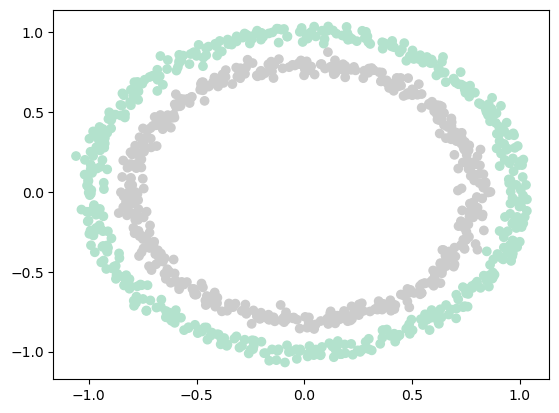

In [12]:
from sklearn.datasets import make_circles

# we can use the make_circles() function from sklearn to generate two different circles
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

# make circles returns two classes of data, so we can use the scatter plot to visualize the data
# The x and y coordinates for each point are stored in X[:,0] and X[:,1] respectively
# The corresponding class label for each point is stored in y
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap='Pastel2')

### Input and output shapes

One of the most common errors in deep learning is shape errors. The best thing to do is continuously familiarize yourself with the shape of the data that you're working with. 

In [13]:
print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f'Values for one sample of X: {X_sample}')
print(f'Value for one sample of y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape}')
print(f'Shape for one sample of y: {y_sample.shape}')


shape of X: (1000, 2)
shape of y: (1000,)
Values for one sample of X: [0.75424625 0.23148074]
Value for one sample of y: 1
Shapes for one sample of X: (2,)
Shape for one sample of y: ()


Okay so X has two dimensions (it is a vector) and y has one dimension (it is a scalar). This means we have two inputs for one output.

### Turn data into tensors and create train/test splits

In [14]:
import torch
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# let's view the first five examples of features and labels
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [15]:
from sklearn.model_selection import train_test_split

# train_test_split randomly partitions the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X,                  # This param is *arrays, pass as many as you want
                                                    y,
                                                    test_size=0.2,      # 20% of the data is used for testing
                                                    random_state=42)    # set the random seed for reproducibility

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a classification model

In [19]:
import torch
from torch import nn

# make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)     # takes in two features (X) and produces 5 features.
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)     # takes in five features (from above) and produces 1 feature (y)

    # our forward pass should return a single feature, the same shape as y
    def forward(self, x): return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features = 2, out_features = 5),
            nn.Linear(in_features = 5, out_features = 1)
        )
    
    def forward(self, x): return self.two_linear_layers(x)

circleModelV3 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
)

Using cpu


Above and below we see three different ways to construct effectivley the same model. The first is the most explicit and (when we get to more complicated architectures, most flexible), and the final is the most concise. 

In [24]:
circleModelV0 = CircleModelV0().to(device)
circleModelV0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
circleModelV1 = CircleModelV1().to(device)
circleModelV1

CircleModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [26]:
circleModelV3 = circleModelV3.to(device)
circleModelV3

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### Making sense of weights and biases

If we take a look at the parameters in our model, we can see a tensor of weights and a tensor of biases for each layer.
- `layer 1 weights`: We have two input variables and 5 output variables so we have a total of 10 weights.
- `layer 1 biases`: We have 5 output variables so we have a total of 5 biases.
- `layer 2 weights`: We have 5 input variables and 1 output variable so we have a total of 5 weights.
- `layer 2 biases`: We have 1 output variable so we have a total of 1 bias.


In [38]:
# switch to the model variable for concision
model = CircleModelV0().to(device)
for param in model.state_dict():
    print(param)
    print(f'{model.state_dict()[param]}\n')

layer_1.weight
tensor([[-0.3849, -0.1222],
        [-0.0765, -0.0577],
        [ 0.1403,  0.2135],
        [ 0.4101,  0.2004],
        [ 0.3487, -0.6327]])

layer_1.bias
tensor([ 0.7051, -0.1784, -0.3425, -0.4458,  0.5333])

layer_2.weight
tensor([[-0.3370,  0.2587, -0.2820, -0.2705,  0.1819]])

layer_2.bias
tensor([0.3043])



### Create a loss function and optimizer

In [39]:
# If we are working with binary classification problems (which we are), we want to use binary cross entropy loss
# PyTorch has two implementations of BCE: nn.BCELoss() and nn.BCEWithLogitsLoss(), the latter of which is more numerically stable
loss_fxn = nn.BCEWithLogitsLoss()

# We also have many choices for optimizers, but we'll stick with stochastic gradient descent
learning_rate = 0.1
optimizer = torch.optim.SGD(params = model.parameters(), 
                            lr = learning_rate)

### Evaluation metrics

The loss functions tells us how wrong the model is, but we also want to know how right the model is.

#### Accuracy
-`Accuracy` is the number of correct predictions divided by the total number of predictions. E.g., if we have 100 predictions and 90 of them are correct, our accuracy is 90%.

In [40]:
def accuracy_fxn(y_true, y_pred): 
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_true)

### Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

The output of our model is currently in logits, and we need it in probabilities! We can use the `torch.sigmoid()` function to convert our logits to probabilities. HOW DOES IT WORK, THOUGH?

In [41]:
# code

### Training loop! 
1) Forwqard pass - The model goes through all the training data once, performing its forward fnction calculations `y_pred = model(x_train)`
2) Calculate loss - Use the loss fxn to calculate how bad the predictions are `loss = loss_fn(y_pred, y_train)`
3) Zero gradients - We need to zero the gradients before we can calculate them again `optimizer.zero_grad()`
4) Backpropagation - Calculate the radient of the loss wrt the model's parameters `loss.backward()`
5) Update weights - Update the weights of the model `optimizer.step()`


In [42]:
# code